In [1]:
import scanpy as sc
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx

In [2]:
os.chdir('../')

In [262]:
test = sc.read('/projects/b1042/GoyalLab/lschwartz/dl/perturb-seq/data/processed/DatlingerBock2021.h5ad')

In [264]:
test.obs.perturbation.value_counts()

perturbation
control    4496
Name: count, dtype: int64

In [3]:
base_dir = '/home/xlv0877/proj_home/dl/perturb-seq/data/raw'

In [6]:
import anndata as ad
from src.statics import P_COLS, CTRL_KEYS
from src.preprocess import single_perturbation_mask, _find_match_idx, ens_to_symbol, clean_perturbation_labels


def get_meta(adata: ad.AnnData, p_col: str = 'perturbation', ctrl_key: str = 'control', single_perturbations_only: bool = True):
    if p_col not in adata.obs.columns:
        logging.info(f'"{p_col}" not found in adata.obs, looking for alternatives.')
        p_col_idx = _find_match_idx(adata.obs.columns.str.lower(), ref=P_COLS)
        p_col_hit = adata.obs.columns[p_col_idx]
        adata.obs[p_col] = adata.obs[p_col_hit]
        logging.info(f'Found "{p_col_hit}" as perturbation column')
    # Check control key
    if np.sum(adata.obs[p_col]==ctrl_key) == 0:
        logging.info(f'{ctrl_key} not found in "{p_col}", looking for alternatives.')
        all_ps = adata.obs[p_col].unique()
        ctrl_idx = _find_match_idx(pd.Series(all_ps).str.lower(), ref=CTRL_KEYS)
        ctrl_key_hit = all_ps[ctrl_idx]
        adata.obs[p_col] = pd.Series(adata.obs[p_col].str.replace(ctrl_key_hit, ctrl_key))
        logging.info(f'Found "{ctrl_key_hit}" as control key')
    # Filter for single perturbations only
    obs = adata.obs.copy()
    if single_perturbations_only:
        logging.info(f'Filtering column "{p_col}" for single perturbations only')
        sp_mask = single_perturbation_mask(obs, p_col=p_col)
        if sp_mask is not None:
            obs = obs[sp_mask].copy()
    obs[p_col] = clean_perturbation_labels(obs[p_col], keep_versions=False)
    # Extract .var
    var = adata.var.copy()
    if adata.var_names.str.lower().str.startswith('ens').all():
        logging.info(f'Dataset .var indices are ensembl ids, attempting transfer to gene symbols using internal adata.var.')
        var = ens_to_symbol(adata).var.copy()
    return obs, var

In [7]:
# Collect meta data for all available datasets
meta = []
var = []
for file in os.listdir(base_dir):
    if file.endswith('h5ad'):
        print(file)
        adata = sc.read(os.path.join(base_dir, file), backed='r')
        m, v = get_meta(adata)
        m['dataset'] = file.split('.h5ad')[0]
        m.index = m.index.astype(str) + m['dataset'].astype(str)
        meta.append(m)
        var.append(v)
        adata.file.close()
meta = pd.concat(meta, axis=0)

ReplogleWeissman2025_Jurkat.h5ad


2025-07-10 15:16:17,225 - INFO - "perturbation" not found in adata.obs, looking for alternatives.
2025-07-10 15:16:17,226 - INFO - Found "gene" as perturbation column
2025-07-10 15:16:17,227 - INFO - control not found in "perturbation", looking for alternatives.
2025-07-10 15:16:17,234 - INFO - Found "non-targeting" as control key
2025-07-10 15:16:17,238 - INFO - Filtering column "perturbation" for single perturbations only
2025-07-10 15:16:18,044 - INFO - Dataset .var indices are ensembl ids, attempting transfer to gene symbols using internal adata.var.
2025-07-10 15:16:18,049 - INFO - Found duplicate indices for ensembl to symbol mapping, highest number of conflicts: 2
2025-07-10 15:16:18,360 - INFO - Filtering column "perturbation" for single perturbations only


TianKampmann2021_CRISPRa.h5ad
ReplogleWeissman2025_HepG2.h5ad


2025-07-10 15:16:18,747 - INFO - "perturbation" not found in adata.obs, looking for alternatives.
2025-07-10 15:16:18,749 - INFO - Found "gene" as perturbation column
2025-07-10 15:16:18,749 - INFO - control not found in "perturbation", looking for alternatives.
2025-07-10 15:16:18,754 - INFO - Found "non-targeting" as control key
2025-07-10 15:16:18,756 - INFO - Filtering column "perturbation" for single perturbations only
2025-07-10 15:16:19,346 - INFO - Dataset .var indices are ensembl ids, attempting transfer to gene symbols using internal adata.var.
2025-07-10 15:16:19,349 - INFO - Found duplicate indices for ensembl to symbol mapping, highest number of conflicts: 2


XAtlas2025_HCT116.h5ad


2025-07-10 15:16:24,292 - INFO - "perturbation" not found in adata.obs, looking for alternatives.
2025-07-10 15:16:24,300 - INFO - Found "gene_target" as perturbation column
2025-07-10 15:16:24,304 - INFO - control not found in "perturbation", looking for alternatives.
2025-07-10 15:16:24,382 - INFO - Found "Non-Targeting" as control key
2025-07-10 15:16:24,430 - INFO - Filtering column "perturbation" for single perturbations only


TianKampmann2019_iPSC.h5ad


2025-07-10 15:16:35,267 - INFO - Filtering column "perturbation" for single perturbations only


TianKampmann2021_CRISPRi.h5ad


2025-07-10 15:16:36,214 - INFO - Filtering column "perturbation" for single perturbations only


ReplogleWeissman2022_rpe1.h5ad


2025-07-10 15:16:36,962 - INFO - Filtering column "perturbation" for single perturbations only


XAtlas2025_HEK293T.h5ad


2025-07-10 15:16:44,112 - INFO - "perturbation" not found in adata.obs, looking for alternatives.
2025-07-10 15:16:44,115 - INFO - Found "gene_target" as perturbation column
2025-07-10 15:16:44,119 - INFO - control not found in "perturbation", looking for alternatives.
2025-07-10 15:16:44,214 - INFO - Found "Non-Targeting" as control key
2025-07-10 15:16:44,280 - INFO - Filtering column "perturbation" for single perturbations only


DatlingerBock2021.h5ad


2025-07-10 15:16:59,093 - INFO - Filtering column "perturbation" for single perturbations only


ReplogleWeissman2022_K562_gwps.h5ad


2025-07-10 15:17:02,760 - INFO - Filtering column "perturbation" for single perturbations only


ShifrutMarson2018.h5ad


2025-07-10 15:17:06,841 - INFO - Filtering column "perturbation" for single perturbations only


TianKampmann2019_day7neuron.h5ad


2025-07-10 15:17:07,649 - INFO - Filtering column "perturbation" for single perturbations only


FrangiehIzar2021_RNA.h5ad


2025-07-10 15:17:08,561 - INFO - Filtering column "perturbation" for single perturbations only


ReplogleWeissman2022_K562_essential.h5ad


2025-07-10 15:17:09,583 - INFO - Filtering column "perturbation" for single perturbations only


NormanWeissman2019_filtered.h5ad


2025-07-10 15:17:10,451 - INFO - Filtering column "perturbation" for single perturbations only


In [155]:
var = pd.concat(var, axis=1)

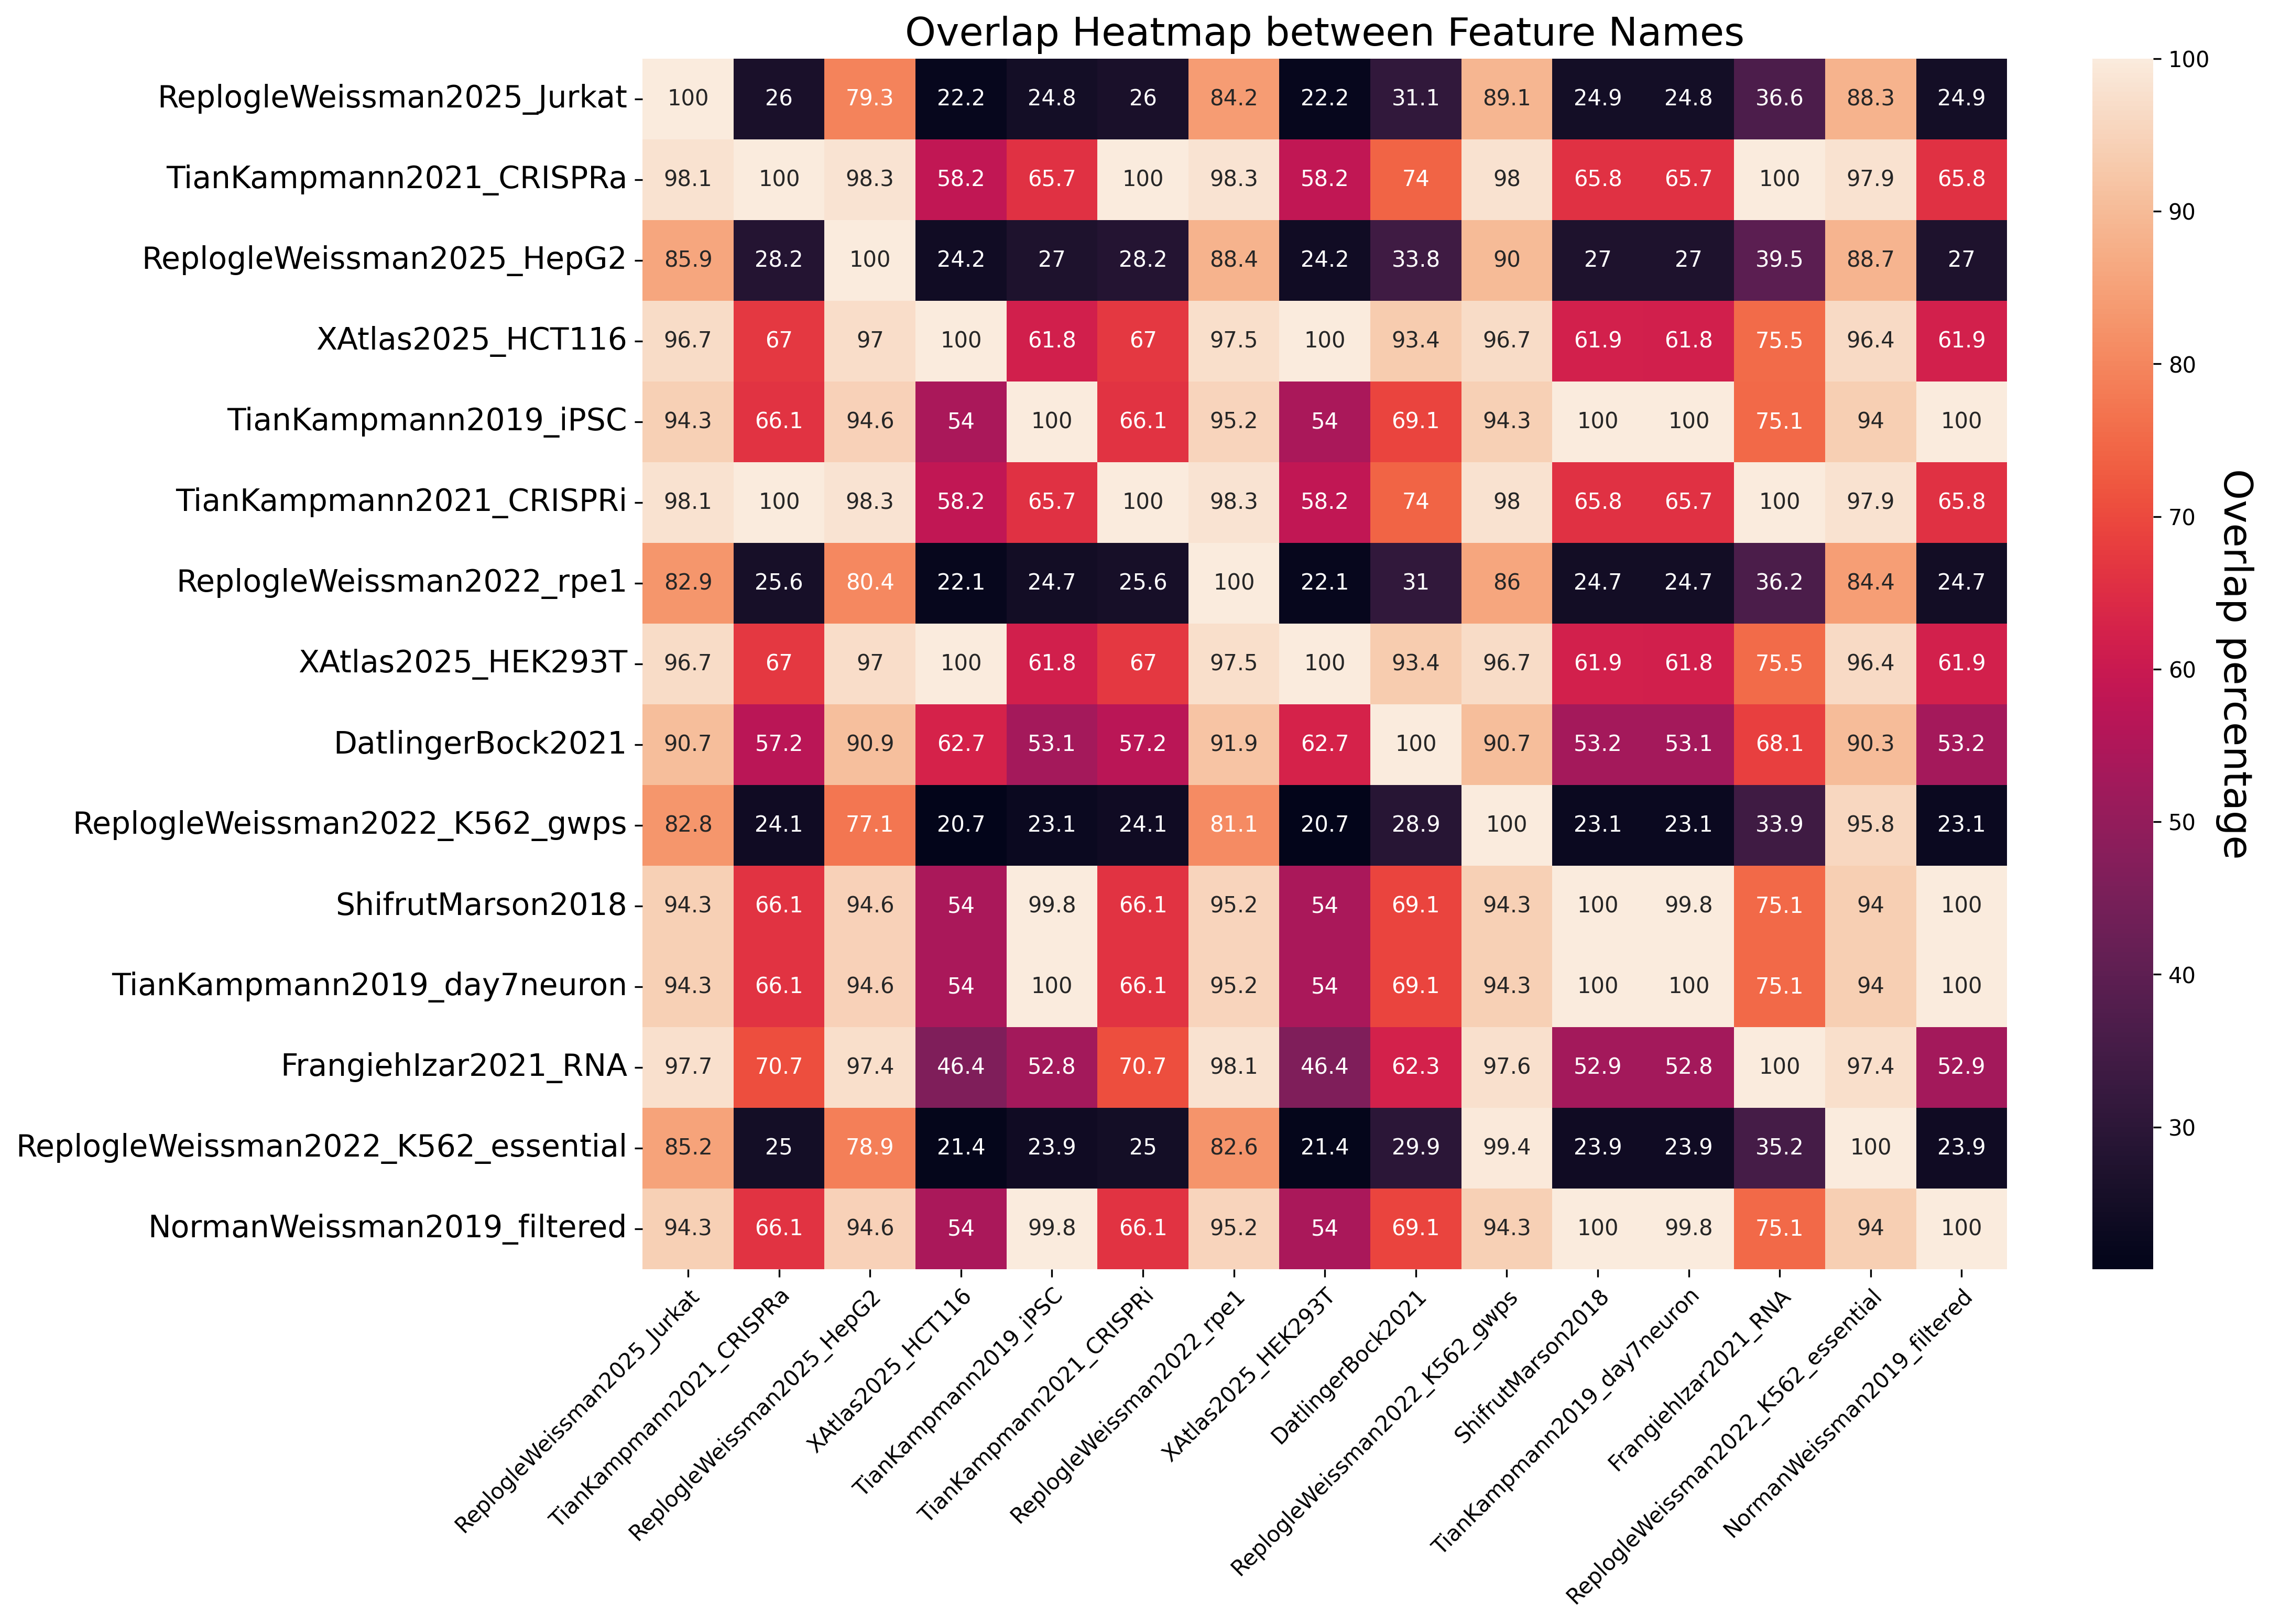

In [8]:
# Check overlap in gene names
# check overlap in perturbations


groups = meta.dataset.unique()
unique_values = [set(v.index) for v in var]
overlap_matrix = np.zeros((len(groups), len(groups)))

for i, group1 in enumerate(groups):
    for j, group2 in enumerate(groups):
        both = len(set(unique_values[i]).intersection(unique_values[j]))
        total = len(set(unique_values[i]).union(set(unique_values[j])))
        n_g1 = len(set(unique_values[i]))
        n_g2 = len(set(unique_values[j]))
        perc = np.round(both/n_g1*100, 1)
        overlap_matrix[i, j] = perc

# Create a heatmap
fig = plt.figure(dpi=300, figsize=(14,10))
ax = sns.heatmap(overlap_matrix.T, xticklabels=groups, yticklabels=groups, fmt='g', annot=True)
cbar = ax.collections[0].colorbar  # Get the colorbar object
cbar.set_label('Overlap percentage', rotation=270, labelpad=20, fontsize=18)
plt.title("Overlap Heatmap between Feature Names", fontsize=18)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
#plt.xticks([])
plt.yticks(fontsize=14)
plt.show()

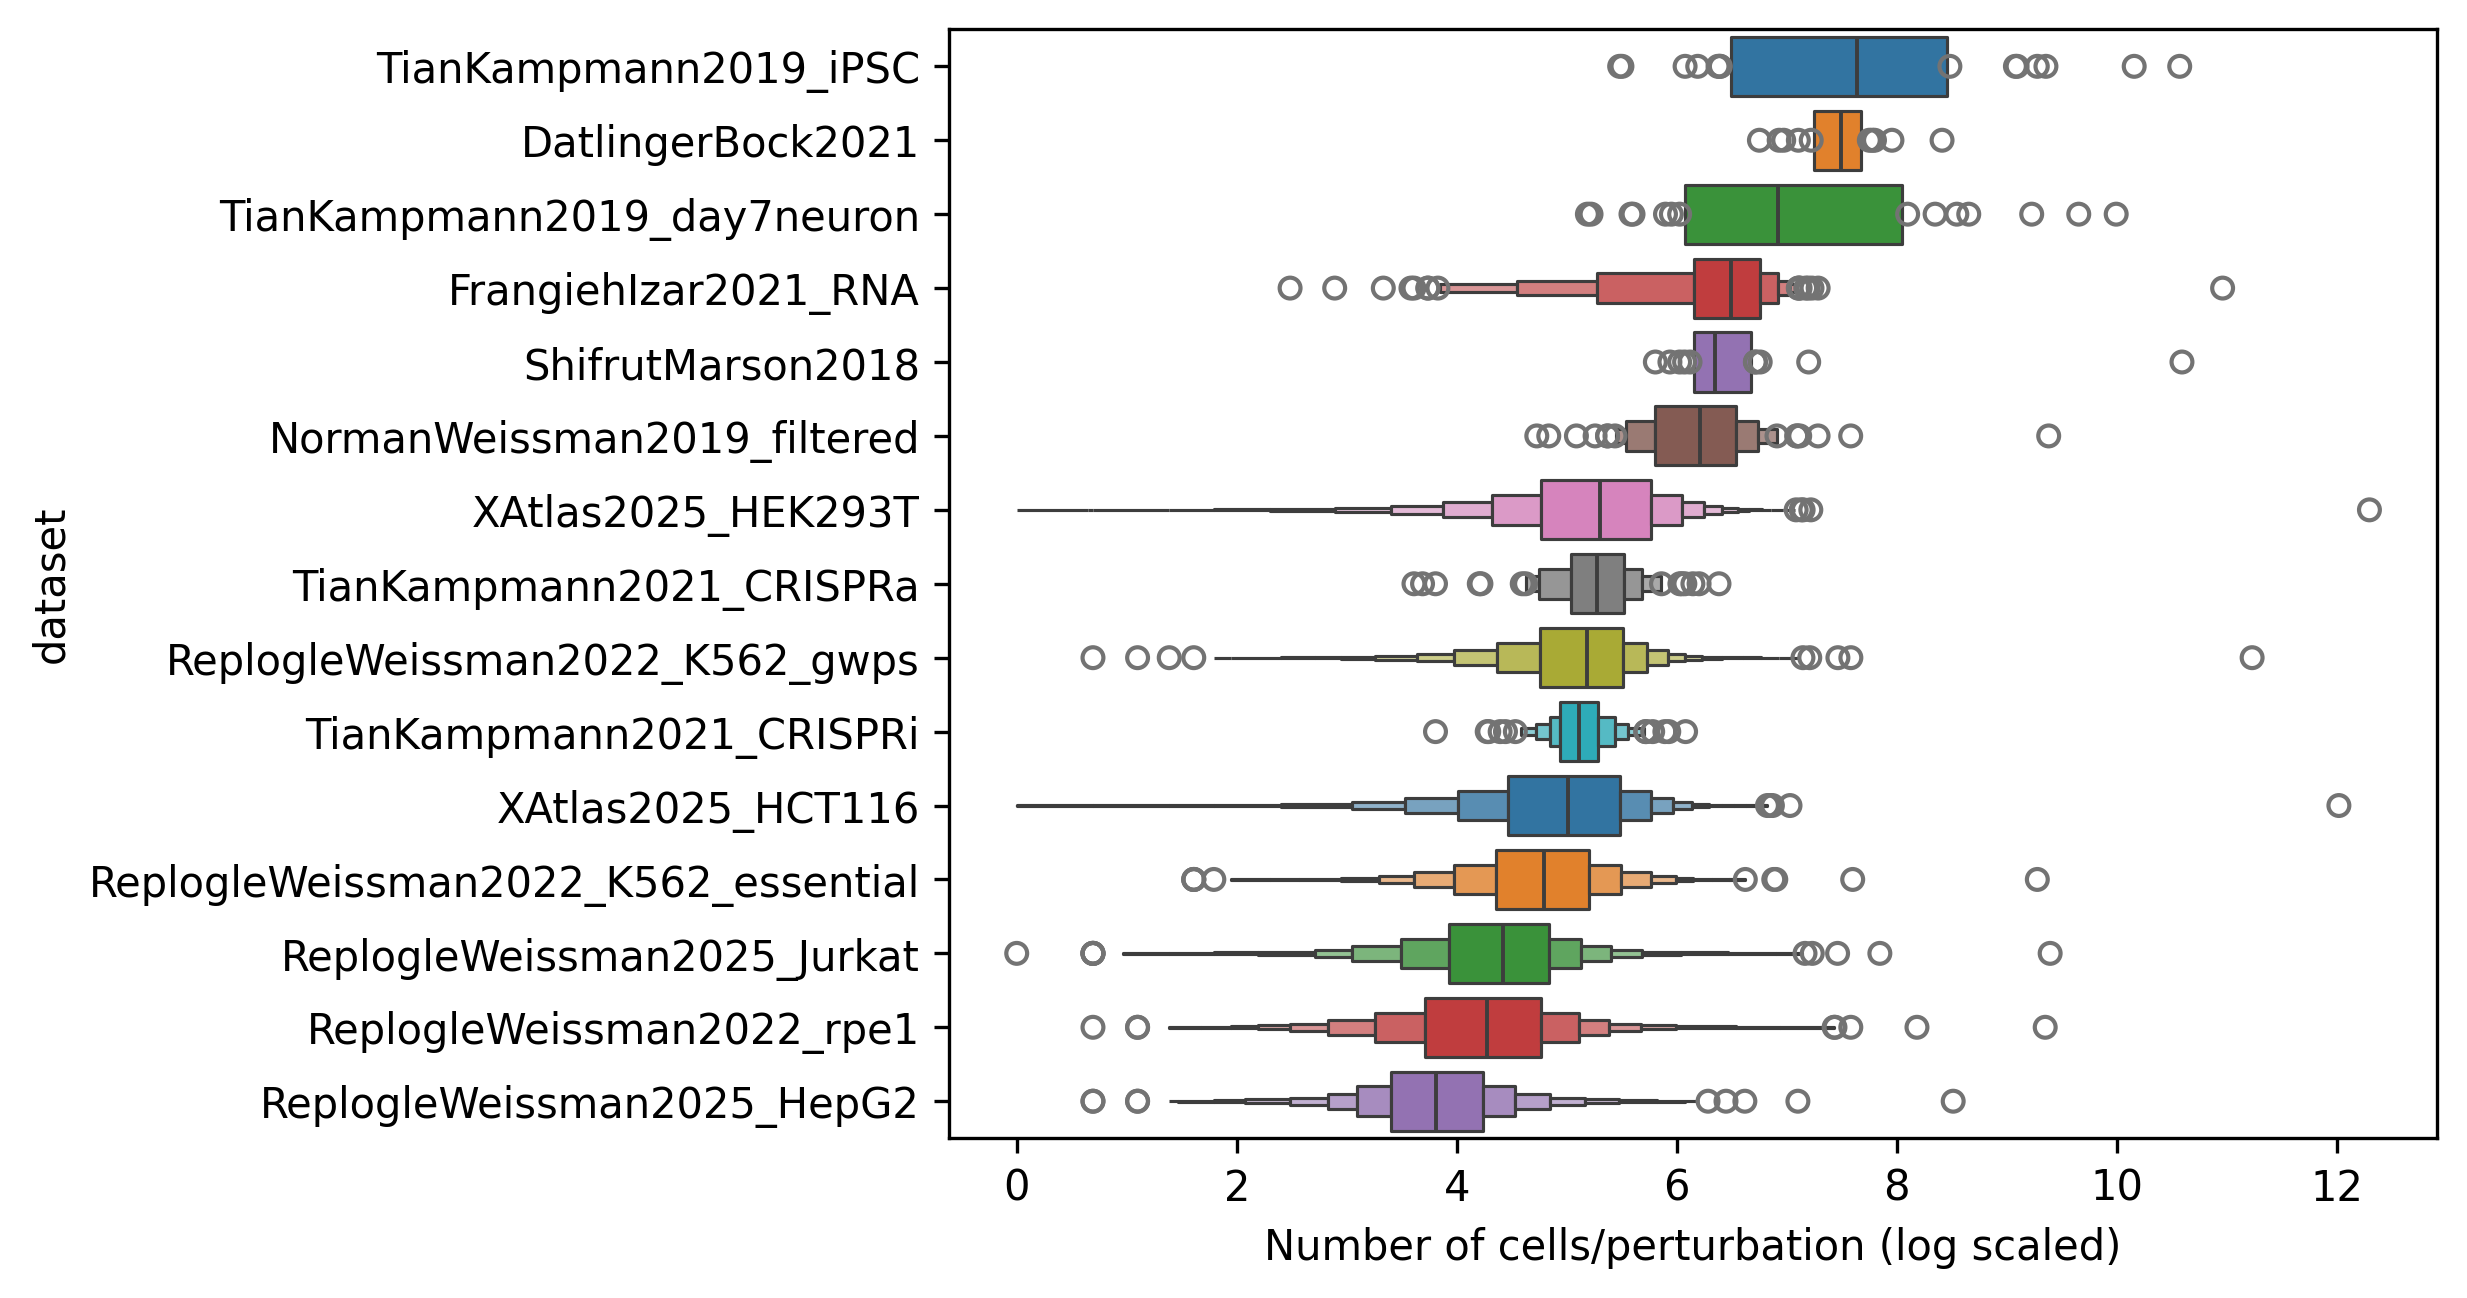

In [260]:
# check number of cells/perturbation
df = meta.groupby(['dataset', 'perturbation']).size().reset_index()
df.columns = ['dataset', 'perturbation', 'n_cells']
df = df[df.n_cells > 0]
df['n_cells_log'] = np.log(df.n_cells)
no_ctrl = df[df.perturbation!='control'].copy()
fig = plt.figure(dpi=300)
df.dataset = pd.Categorical(df.dataset, categories=df.groupby('dataset')['n_cells_log'].median().sort_values(ascending=False).index)
ax = sns.boxenplot(df, x='n_cells_log', y='dataset', palette='tab10', hue='dataset')
plt.xlabel('Number of cells/perturbation (log scaled)')
plt.title('')
plt.show()

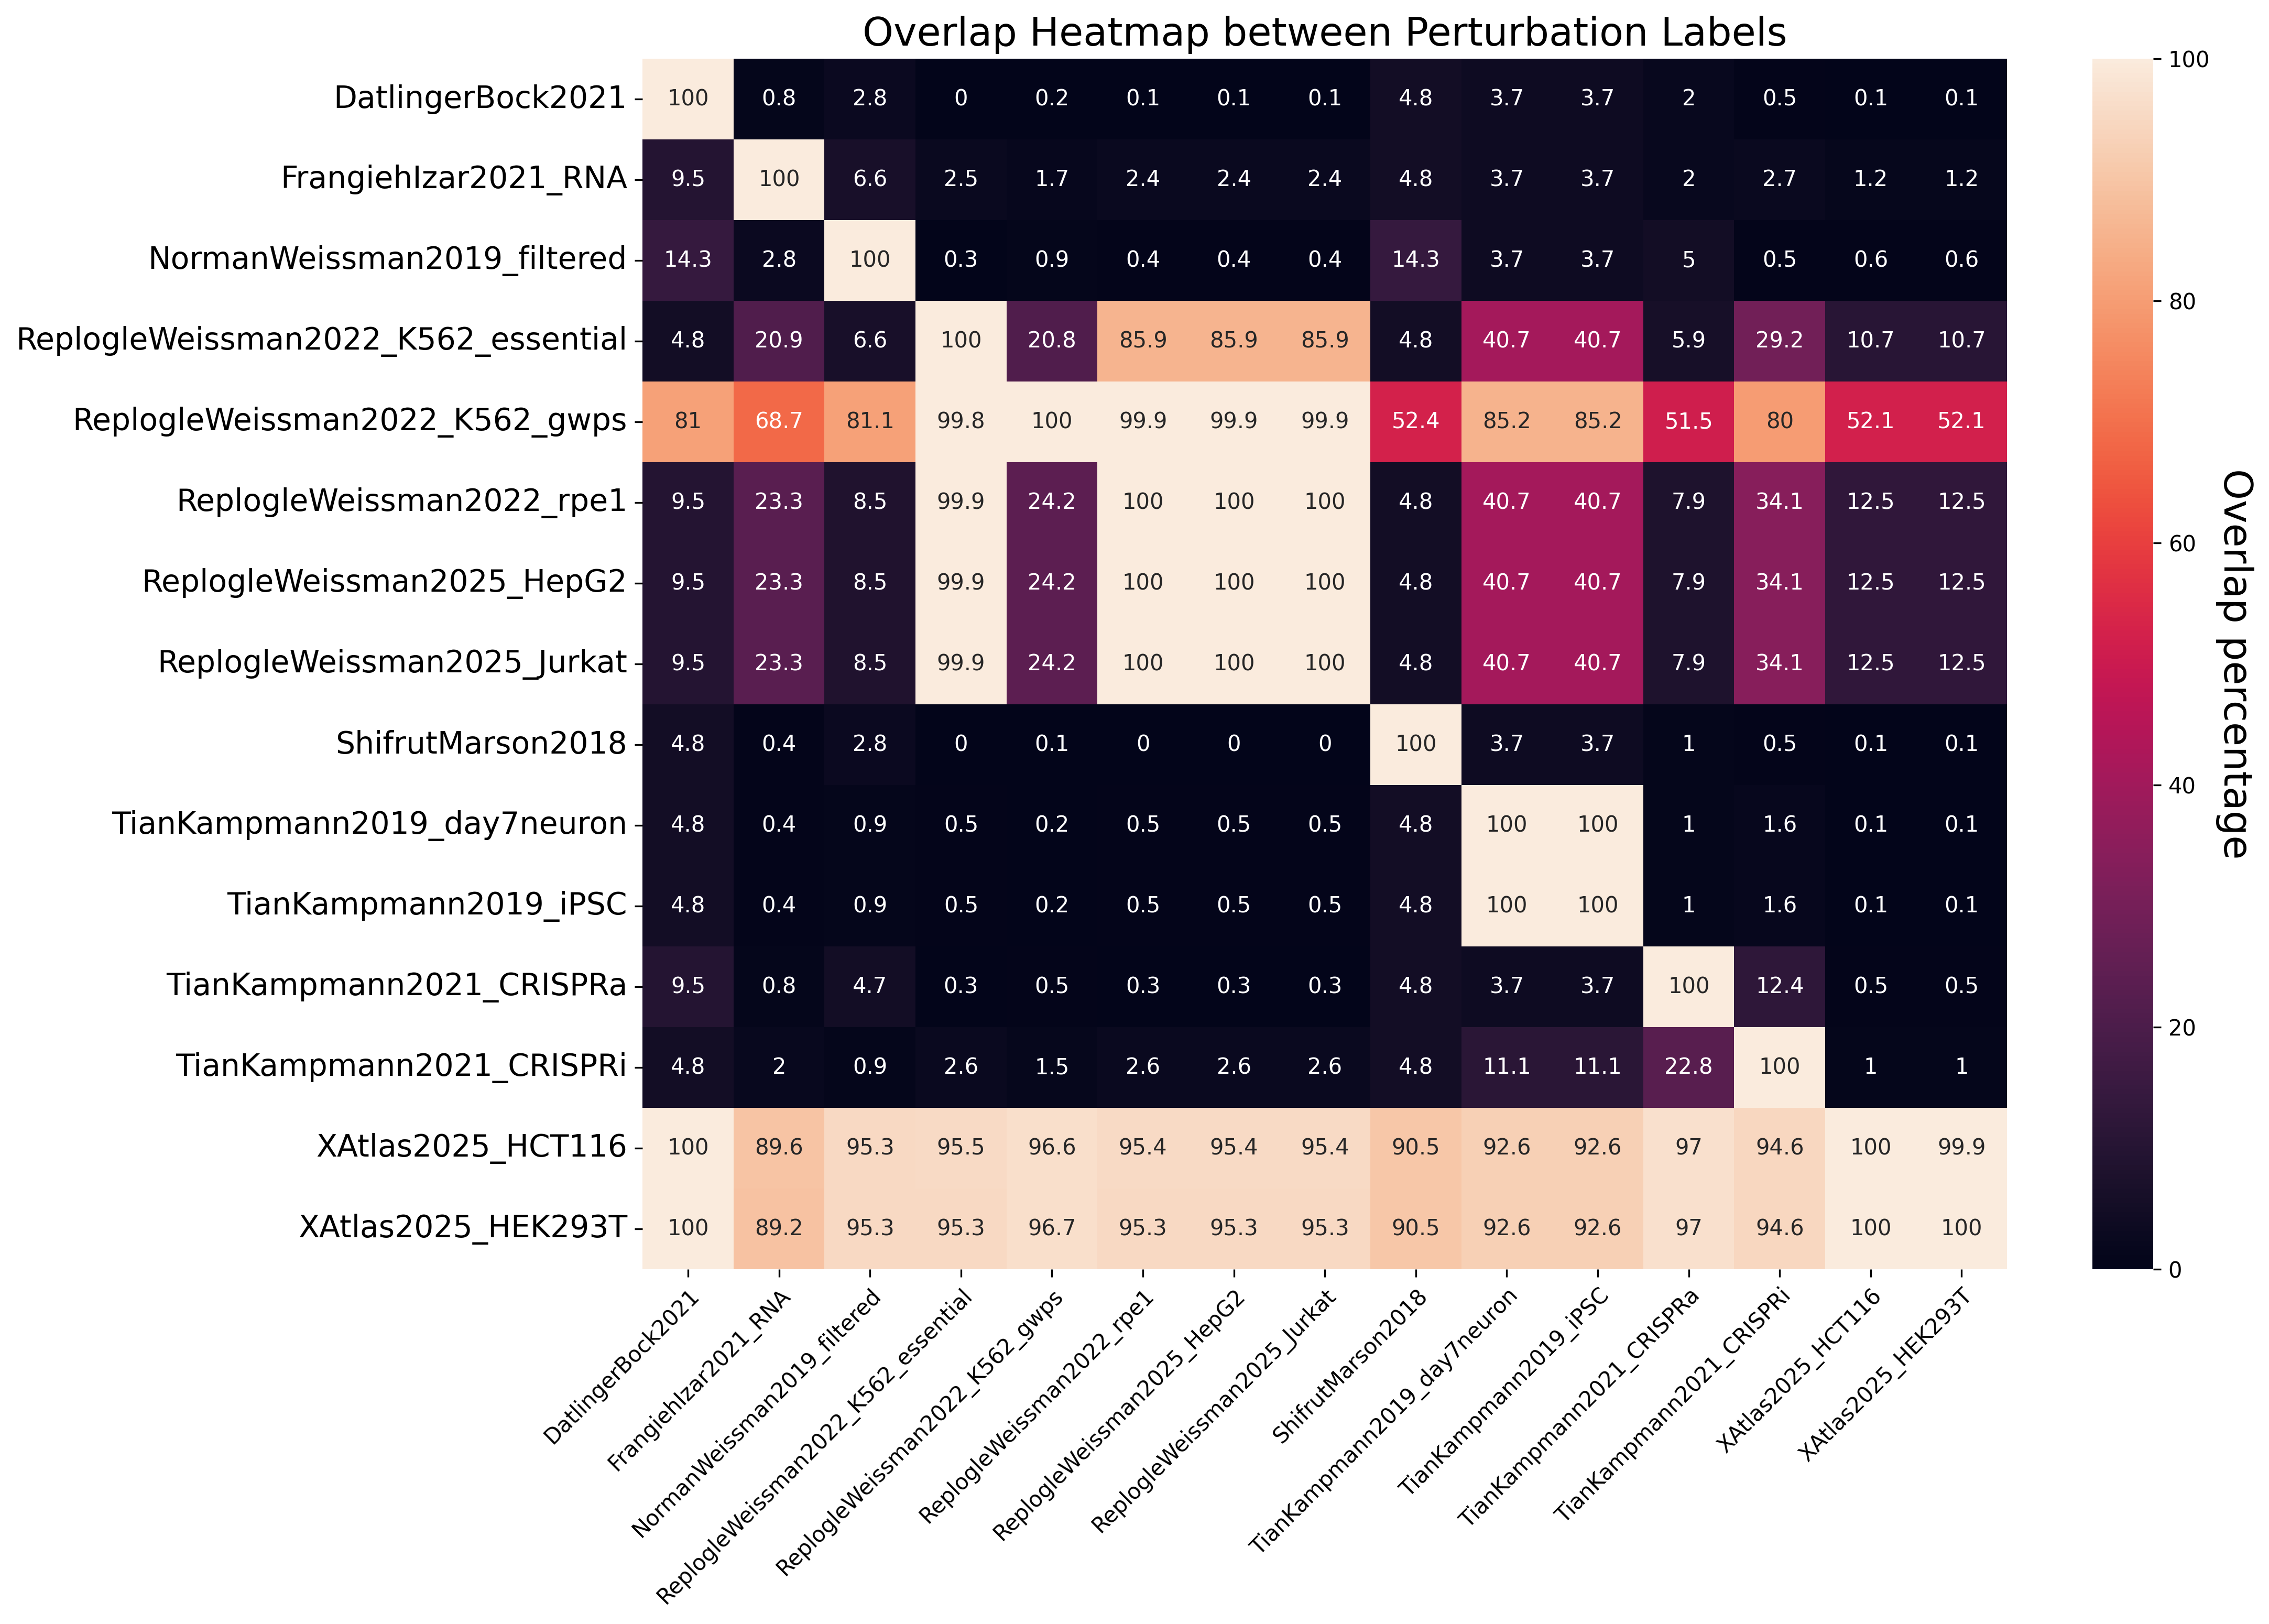

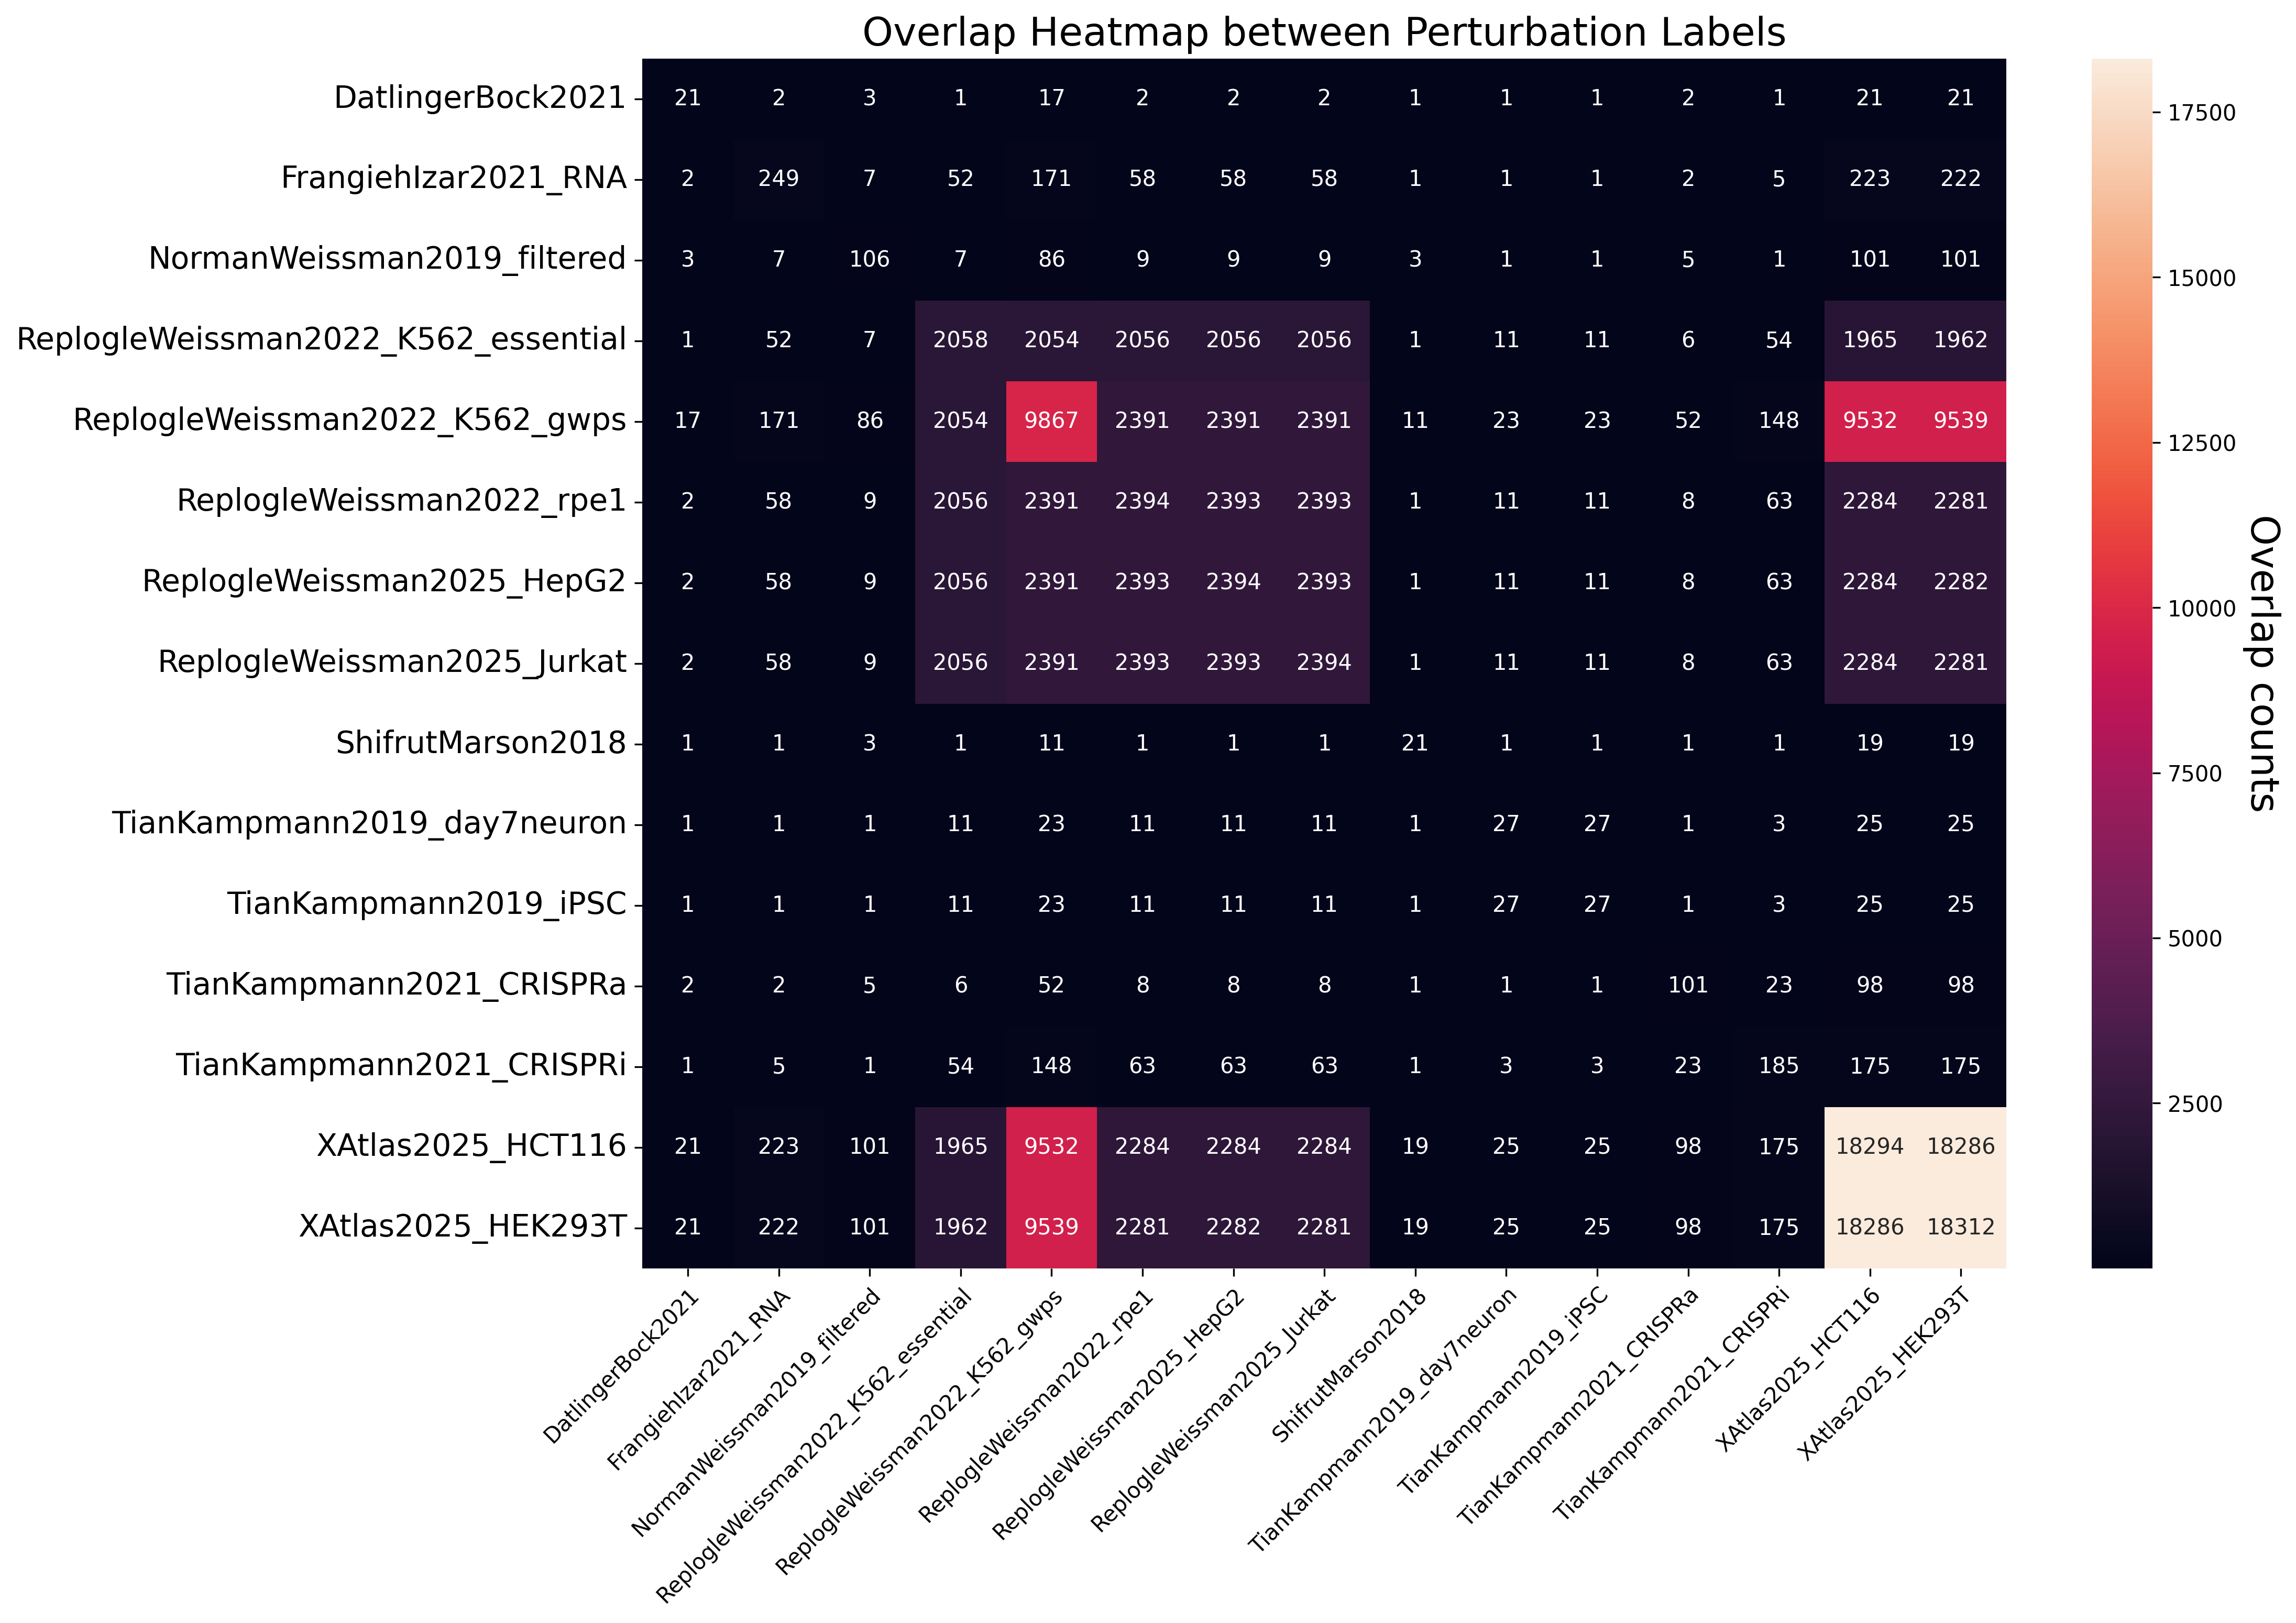

In [156]:
# check overlap in perturbations

df = meta
unique_values = df.groupby('dataset')['perturbation'].unique()
groups = unique_values.keys()
overlap_matrix = np.zeros((len(groups), len(groups)))
total_overlap_matrix = np.zeros((len(groups), len(groups)))

for i, group1 in enumerate(groups):
    for j, group2 in enumerate(groups):
        both = len(set(unique_values[group1]).intersection(unique_values[group2]))
        total = len(set(unique_values[group1]).union(set(unique_values[group2])))
        n_g1 = len(set(unique_values[group1]))
        n_g2 = len(set(unique_values[group2]))
        perc = np.round(both/n_g1*100, 1)
        overlap_matrix[i, j] = perc
        total_overlap_matrix[i, j] = both

# Create a heatmap
fig = plt.figure(dpi=300, figsize=(14,10))
ax = sns.heatmap(overlap_matrix.T, xticklabels=groups, yticklabels=groups, fmt='g', annot=True)
cbar = ax.collections[0].colorbar  # Get the colorbar object
cbar.set_label('Overlap percentage', rotation=270, labelpad=20, fontsize=18)
plt.title("Overlap Heatmap between Perturbation Labels", fontsize=18)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
#plt.xticks([])
plt.yticks(fontsize=14)
plt.show()
fig = plt.figure(dpi=300, figsize=(14,10))
ax = sns.heatmap(total_overlap_matrix.T, xticklabels=groups, yticklabels=groups, fmt='g', annot=True)
cbar = ax.collections[0].colorbar  # Get the colorbar object
cbar.set_label('Overlap counts', rotation=270, labelpad=20, fontsize=18)
plt.title("Overlap Heatmap between Perturbation Labels", fontsize=18)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
#plt.xticks([])
plt.yticks(fontsize=14)
plt.show()

In [11]:
meta.shape

(11558340, 57)

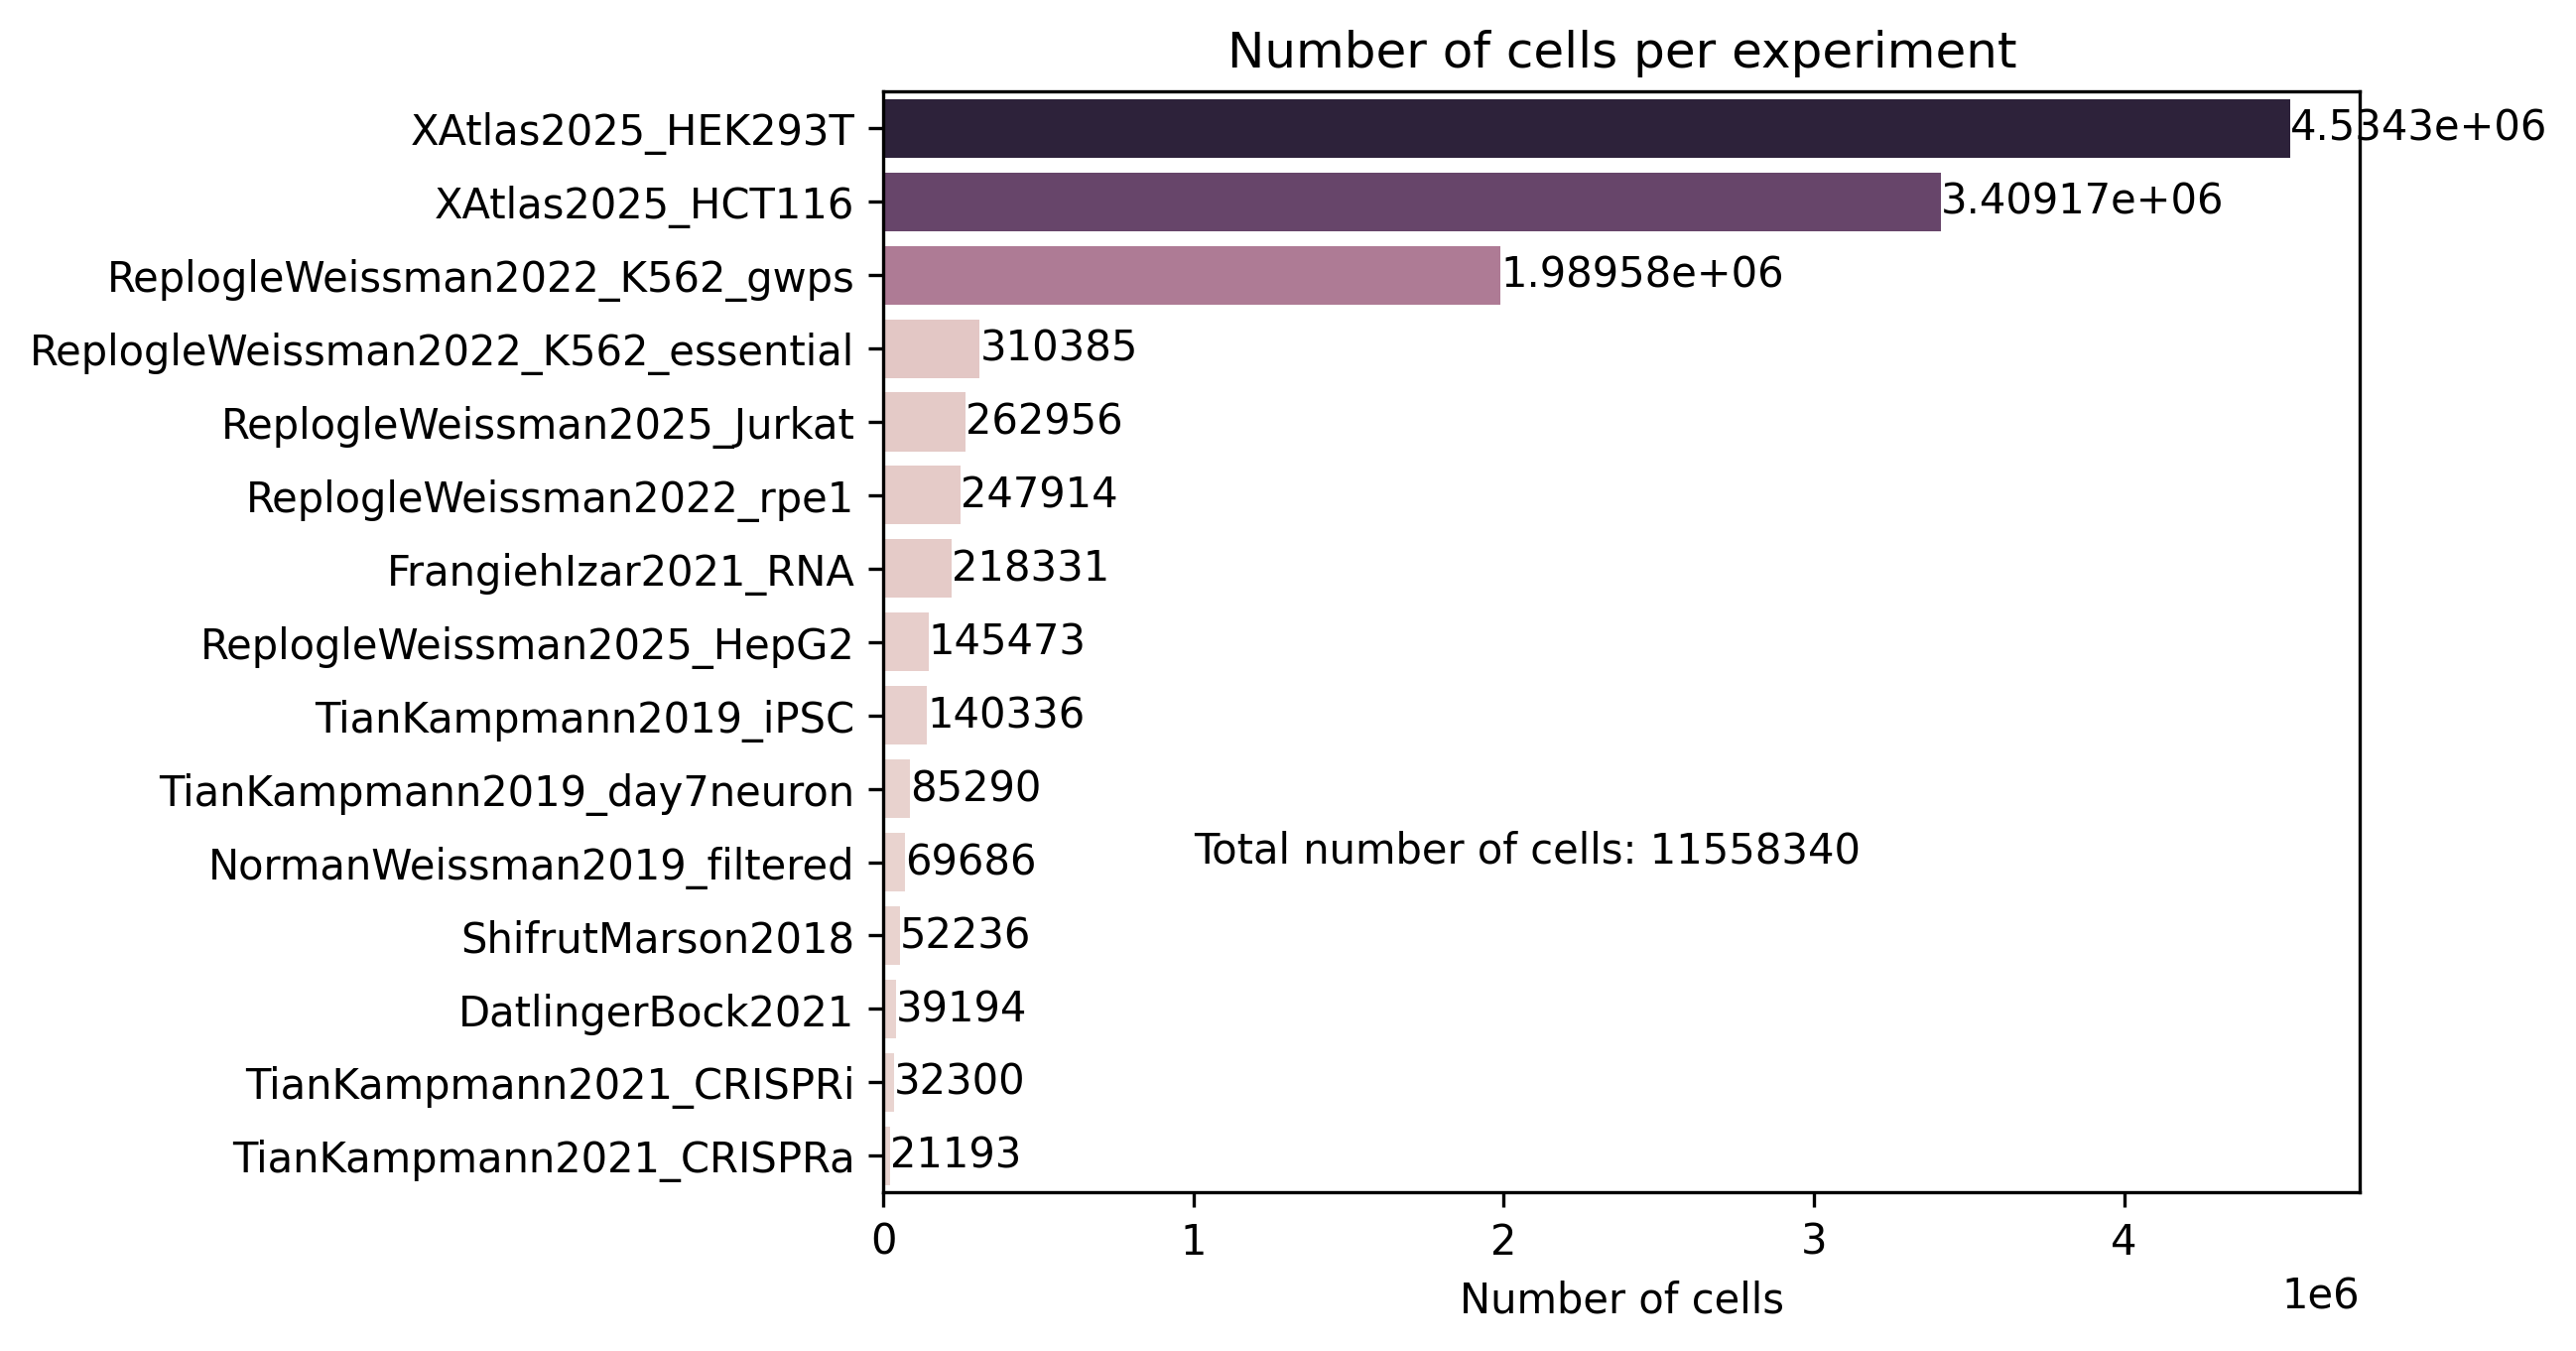

In [12]:
df = pd.DataFrame(meta.dataset.value_counts()).reset_index()
fig = plt.figure(dpi=300)
ax = sns.barplot(df, x='count', y='dataset', orient='y', hue='count', order=df.dataset.values, legend=False)
for c in ax.containers:
    ax.bar_label(c, fontsize=10)
plt.title('Number of cells per experiment')
plt.xlabel('Number of cells')
plt.text(s=f'Total number of cells: {meta.shape[0]}', x=1e6, y=10)
plt.ylabel('')
plt.show()

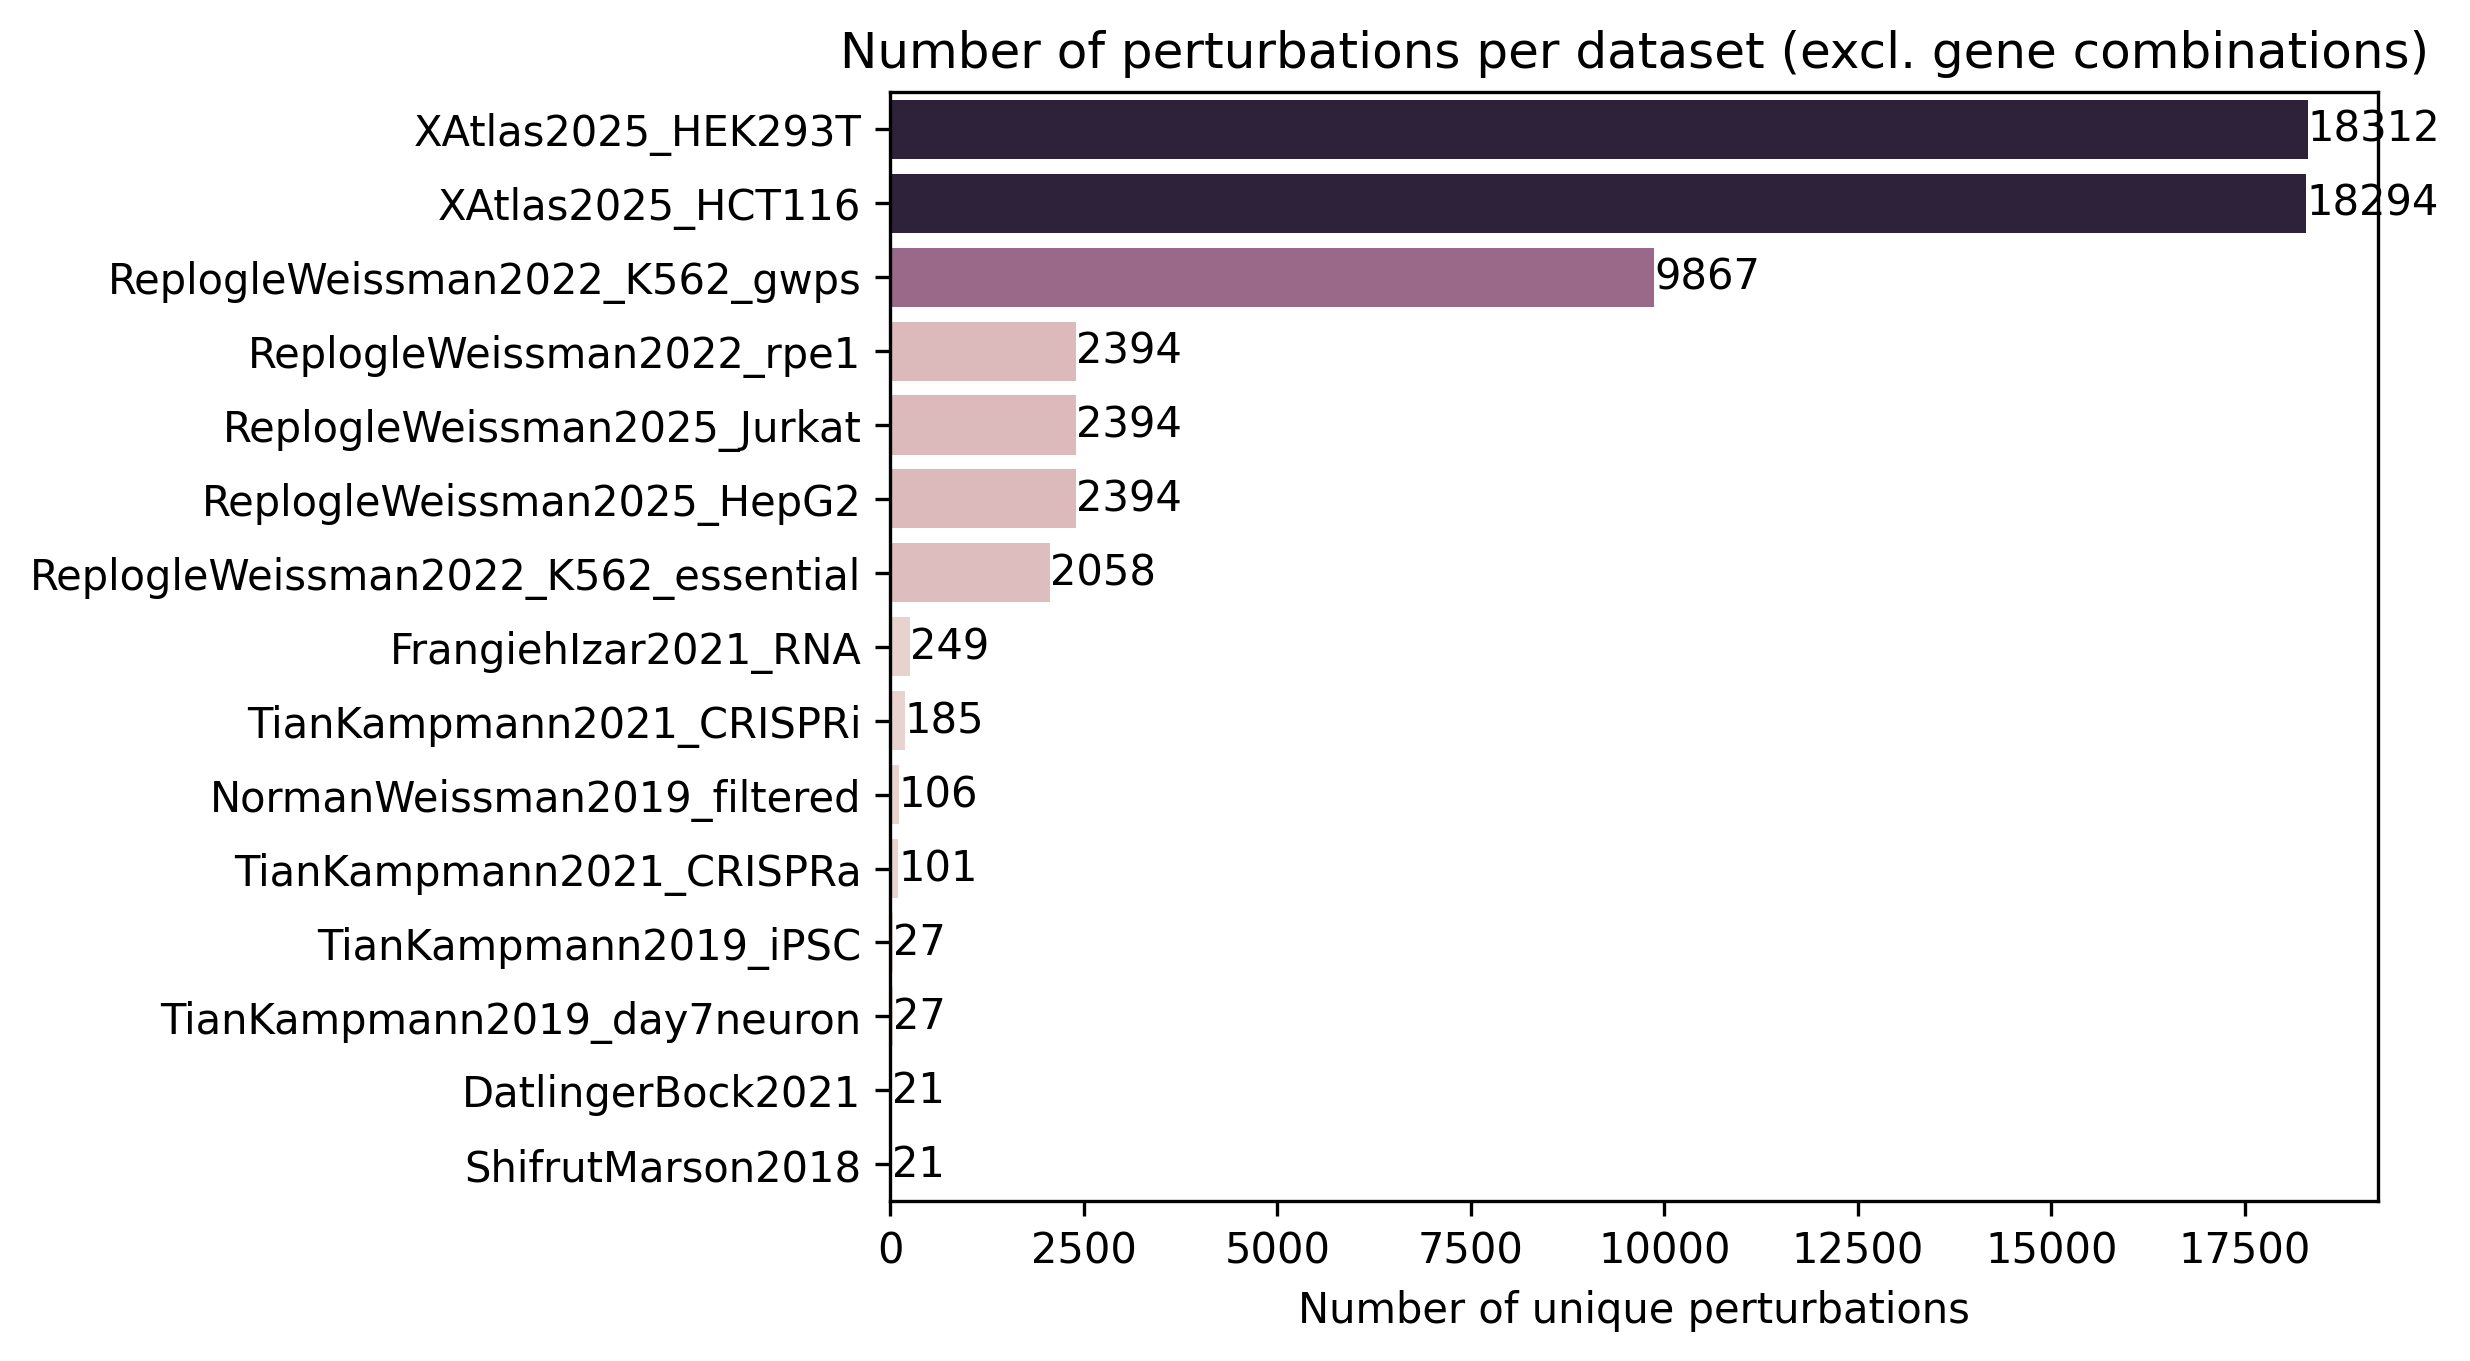

In [13]:
df = meta
df = df.groupby('dataset').perturbation.nunique().reset_index().sort_values('perturbation', ascending=False)
fig = plt.figure(dpi=300)
ax = sns.barplot(df, x='perturbation', y='dataset', orient='y', hue='perturbation', order=df.dataset.values, legend=False)
for c in ax.containers:
    ax.bar_label(c, fontsize=10)
plt.title('Number of perturbations per dataset (excl. gene combinations)')
plt.xlabel('Number of unique perturbations')
plt.ylabel('')
plt.show()

/home/xlv0877/.conda/envs/ExPert/lib/python3.10/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/xlv0877/.conda/envs/ExPert/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewid

<Figure size 1920x1440 with 0 Axes>

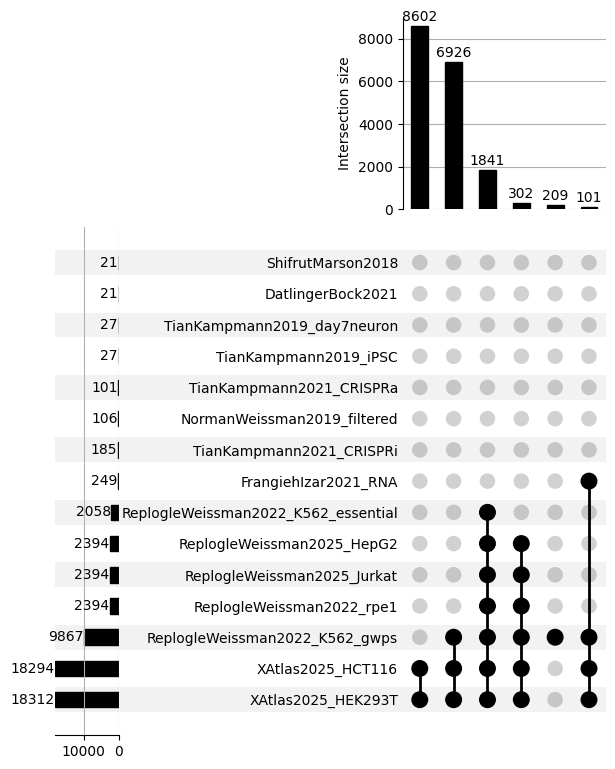

In [143]:
from upsetplot import UpSet, from_contents
import matplotlib.pyplot as plt

# Define input sets
sets = meta.groupby('dataset', observed=True)['perturbation'].apply(lambda x: set(x.unique()))
data = from_contents(sets)
# Plot
plt.figure(dpi=300)
us = UpSet(data, subset_size="count", sort_by="cardinality", min_subset_size=100, show_counts=True)
us.plot()
plt.show()

In [284]:
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd


sets = meta.groupby('dataset', observed=True)['perturbation'].apply(lambda x: set(x.unique()))
all_sets = list(sets.keys())
min_set_size = 100
normalize = False
combos, set_sizes, n_sets, intersections = [], [], [], []
for r in range(1, len(all_sets) + 1):
    for combo in combinations(all_sets, r):
        # Inclusive intersection: intersection of selected sets only
        inter = set.intersection(*(sets[name] for name in combo))
        n = len(inter)
        if n < min_set_size:
            continue
        intersections.append(inter)
        combos.append(combo)
        n_sets.append(len(combo))
        set_sizes.append(n)
intersections = np.array(intersections, dtype=object)
combos = np.array(combos, dtype=object)
set_sizes = np.array(set_sizes)
n_sets = np.array(n_sets)

In [285]:
if False:
    n_sets = n_sets / n_sets.max()
    set_sizes = set_sizes / set_sizes.max()
hm = 2 * n_sets * set_sizes / (n_sets + set_sizes)

In [286]:
best_idx = np.argmax(hm)
pool_datasets = combos[best_idx]

In [287]:
pool_datasets

('ReplogleWeissman2022_K562_essential',
 'ReplogleWeissman2022_K562_gwps',
 'ReplogleWeissman2022_rpe1',
 'ReplogleWeissman2025_HepG2',
 'ReplogleWeissman2025_Jurkat',
 'XAtlas2025_HCT116',
 'XAtlas2025_HEK293T')

In [288]:
perturbation_pool = intersections[best_idx]
print(f'Pool dim: {len(perturbation_pool)} gene-perturbations')

Pool dim: 1959 gene-perturbations


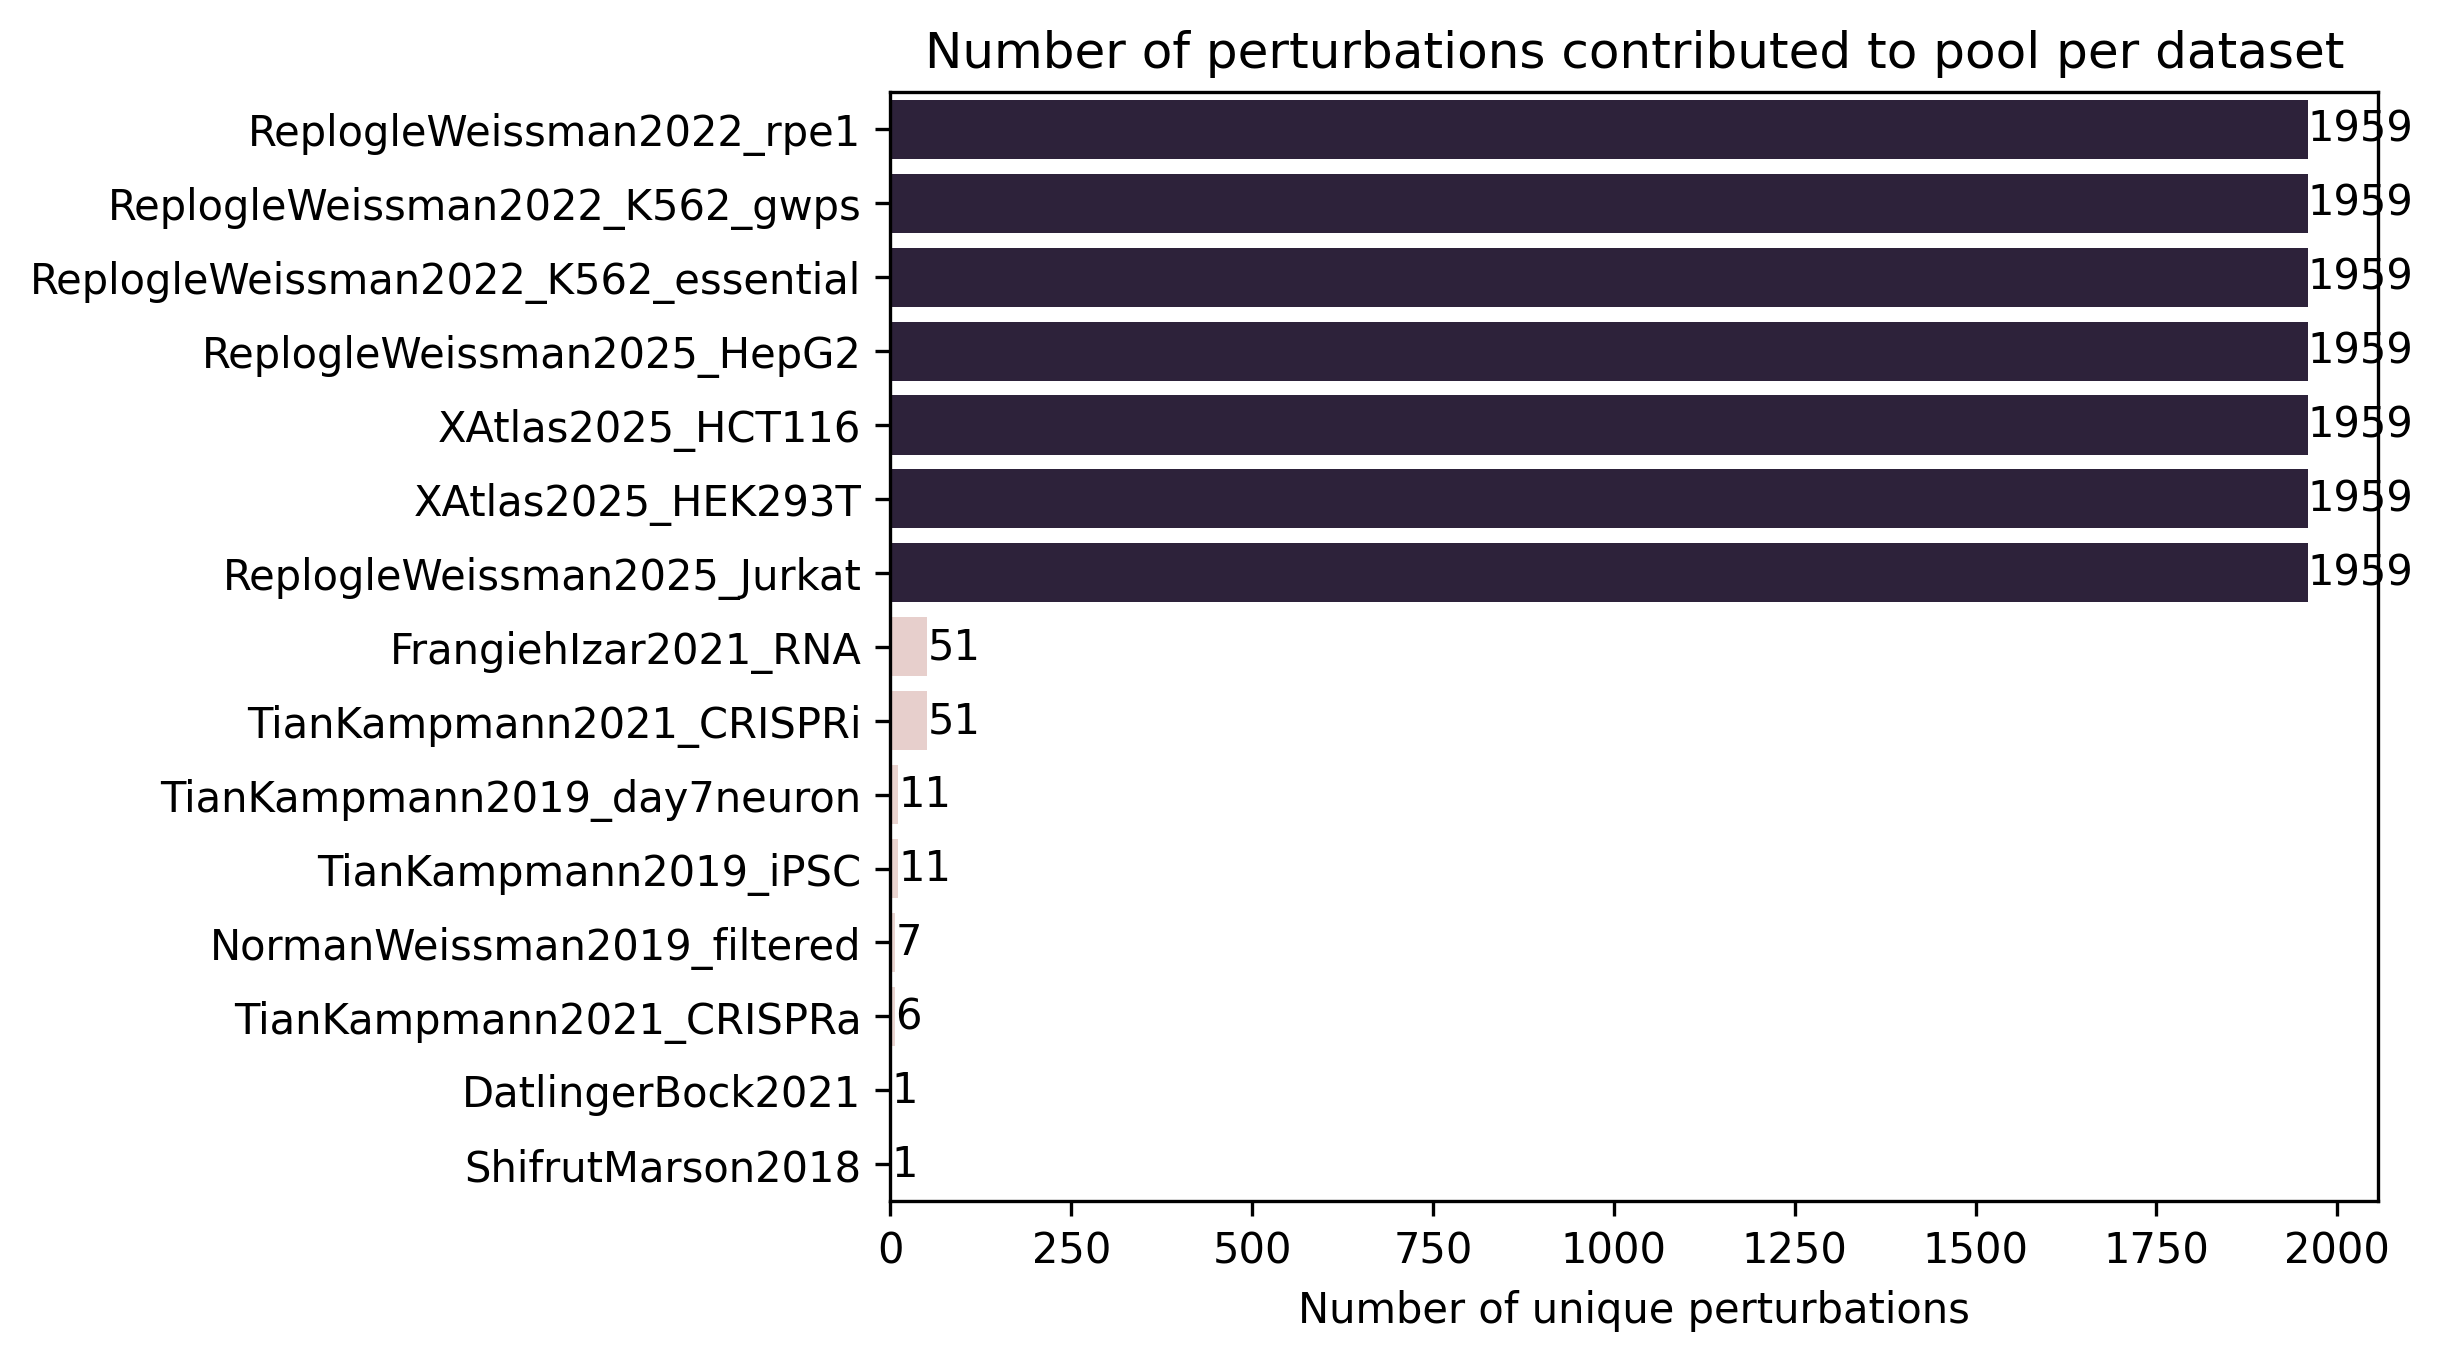

In [289]:
df = meta[meta.perturbation.isin(perturbation_pool)]
df = df.groupby('dataset').perturbation.nunique().reset_index().sort_values('perturbation', ascending=False)
fig = plt.figure(dpi=300)
ax = sns.barplot(df, x='perturbation', y='dataset', orient='y', hue='perturbation', order=df.dataset.values, legend=False)
for c in ax.containers:
    ax.bar_label(c, fontsize=10)
plt.title('Number of perturbations contributed to pool per dataset')
plt.xlabel('Number of unique perturbations')
plt.ylabel('')
plt.show()

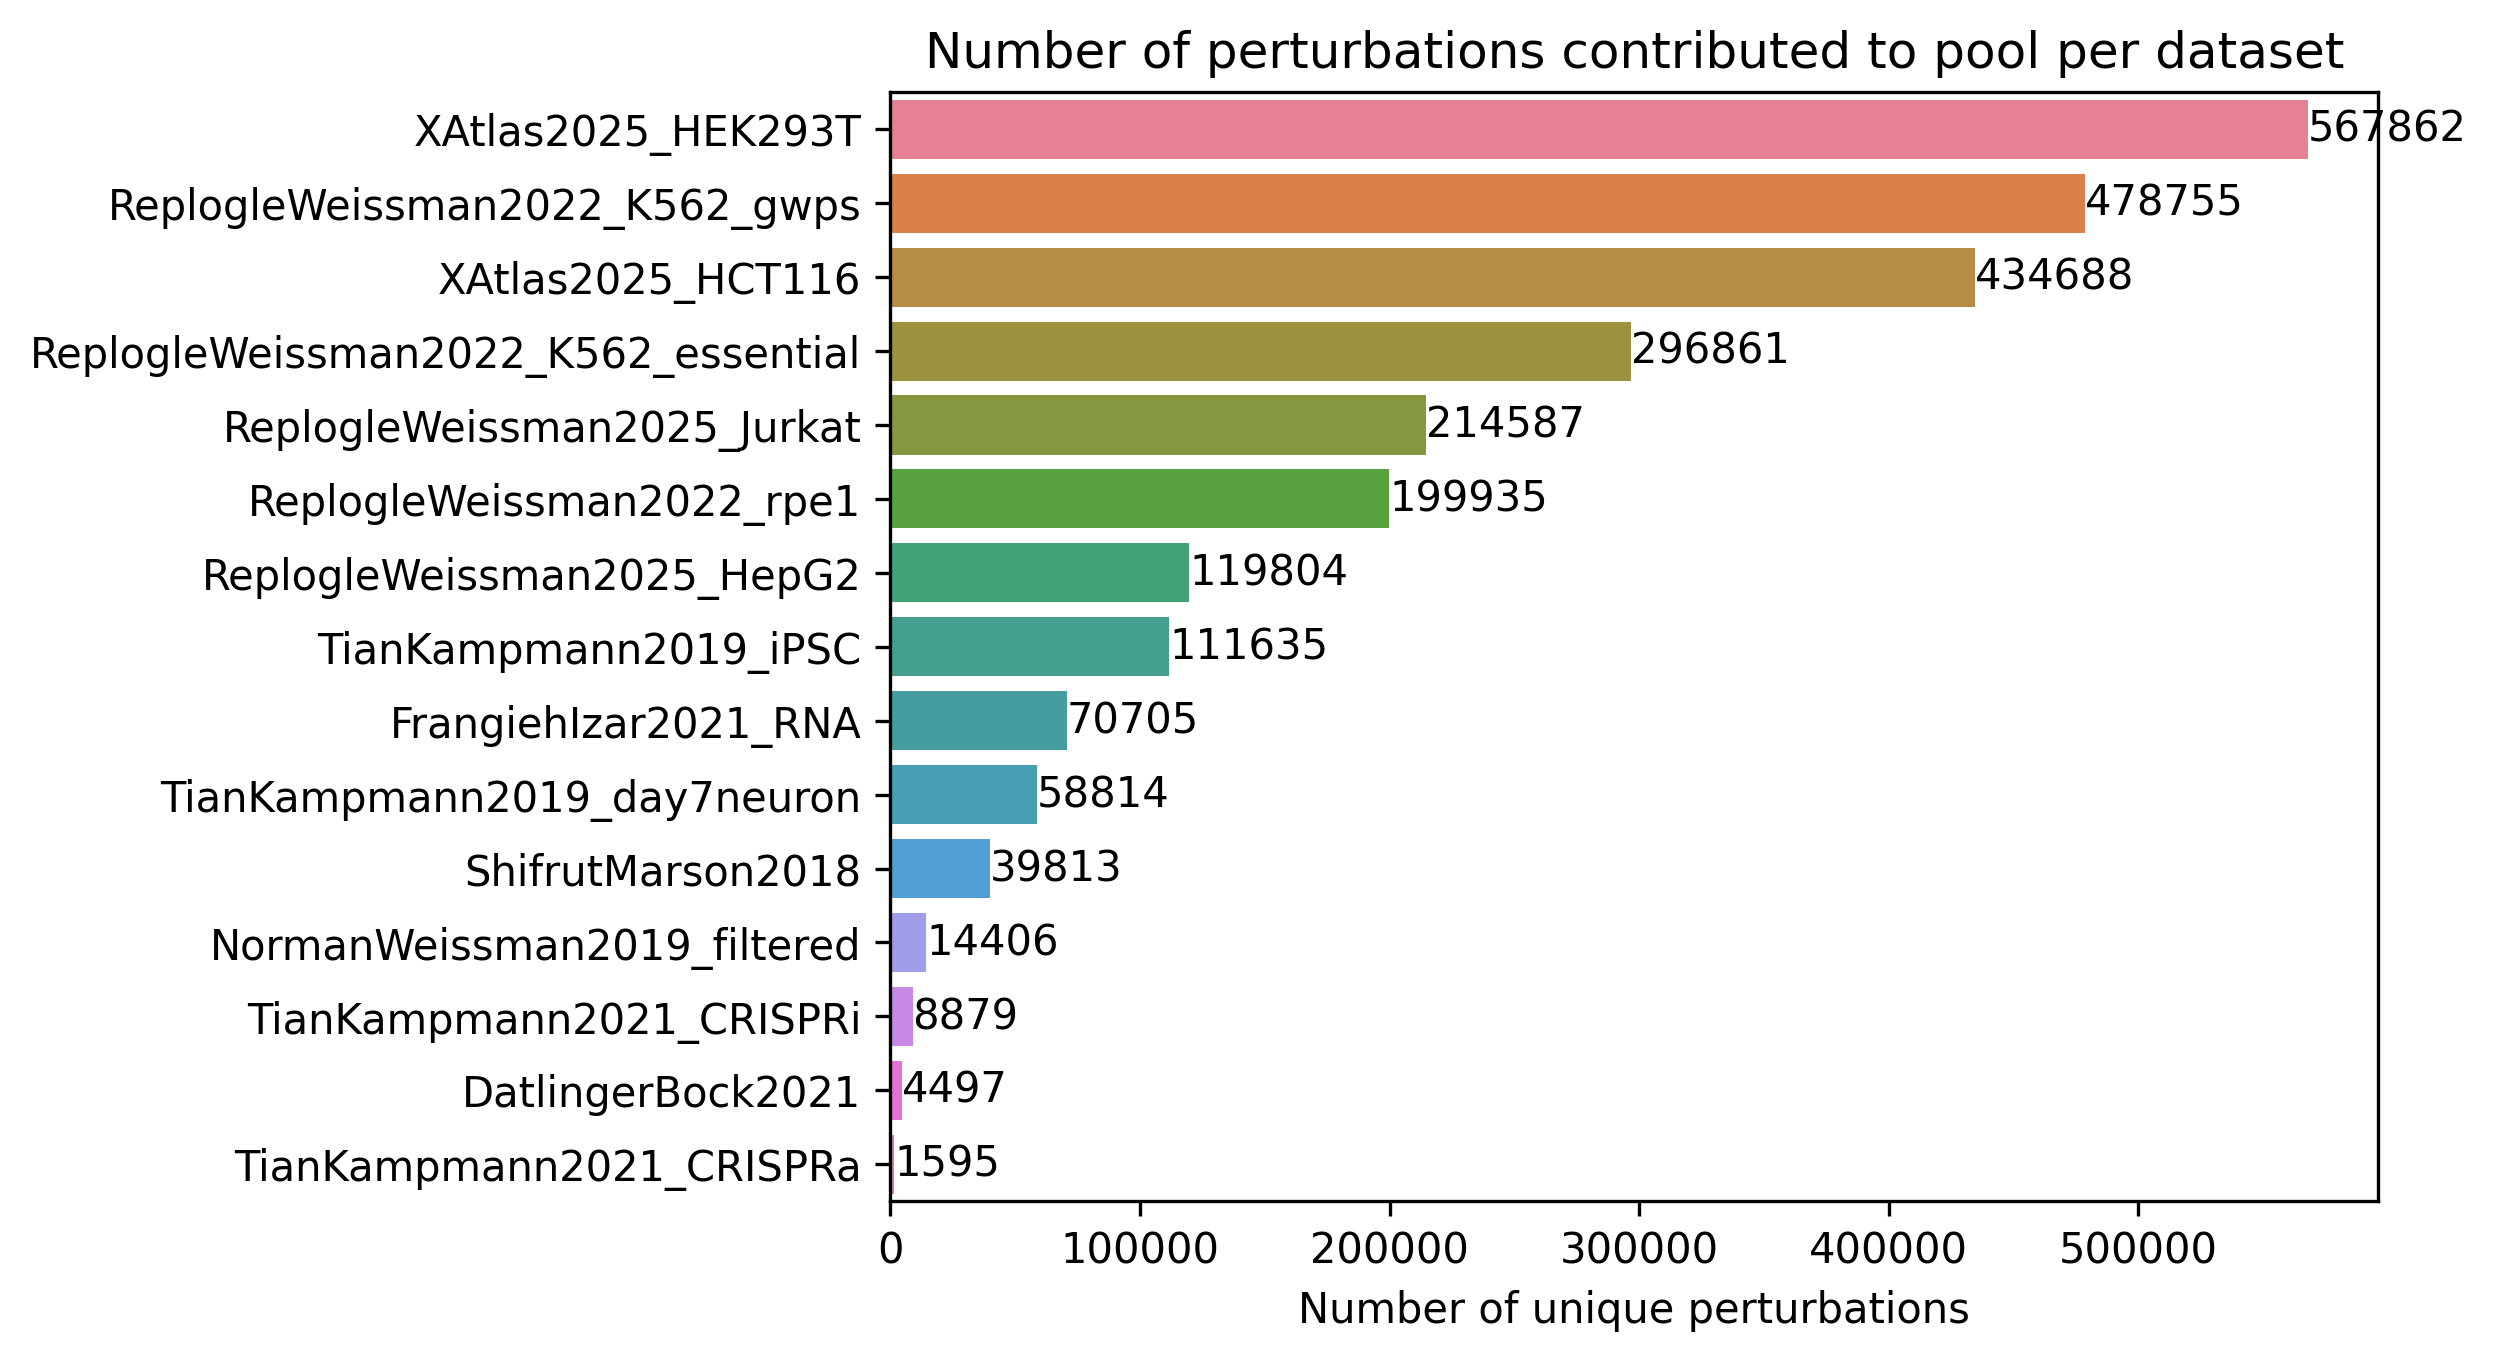

In [290]:
df = meta[meta.perturbation.isin(perturbation_pool)]
df = df.dataset.value_counts().reset_index()
fig = plt.figure(dpi=300)
ax = sns.barplot(df, x='count', y='dataset', orient='y', hue='dataset', order=df.dataset.values, legend=False)
for c in ax.containers:
    ax.bar_label(c, fontsize=10)
plt.title('Number of perturbations contributed to pool per dataset')
plt.xlabel('Number of unique perturbations')
plt.ylabel('')
plt.show()

In [255]:
pp = pd.DataFrame(perturbation_pool, columns=['pool_perturbation'])
pp.to_csv('perturbation_pool.csv')